# Projet de fin de majeure : Super résolution
#### Johanna Dubos, Zoé Ducourau & Dimitri Szezurek
---

In [156]:
# Librairies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil

#### Image considérée (échelle de Monoyer)

Taille de l'image : Hauteur =  943 || Largeur =  768


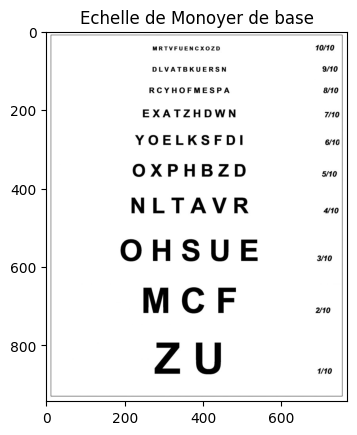

In [157]:
filename = 'Echelle-Monoyer.png'

IMAGE_nb = cv2.imread(filename,0)
[H,W] = IMAGE_nb.shape

print("Taille de l'image : Hauteur = ", H, "|| Largeur = " , W)

plt.imshow(IMAGE_nb,cmap='gray')
plt.title('Echelle de Monoyer de base')
plt.show()

#### Création de la BDD avec N images (déformées, floutées, sous-échantillonées & bruitées)

In [158]:
shutil.rmtree('BDD')
os.makedirs('BDD')

In [159]:
N = 10 # Nb d'images dans la BDD

for i in range (1,N):

    if i == 1:
        img_translated = cv2.warpAffine(IMAGE_nb, np.float32([[1,0,W/2],[0,1,H/2]]),(2*W,2*H)) # Translation
        M = cv2.getRotationMatrix2D((W/2,H/2), 0, 1) # Matrice de rotation
        img_rotated = cv2.warpAffine(img_translated,M,(2*W,2*H)) # Rotation
        img_blurred = cv2.blur(img_rotated,(5,5))   # Floutage 
        img_downsampled = cv2.pyrDown(cv2.pyrDown(img_blurred)) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        gauss = gauss.reshape(img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_1.png",img_noisy,cmap='gray')

    else:
        img_translated = cv2.warpAffine(IMAGE_nb, np.float32([[1,0,np.random.randint(W/2)],[0,1,np.random.randint(H/2)]]),(2*W,2*H)) # Translation
        angle=np.random.randint(-10,10)
        M = cv2.getRotationMatrix2D((W/2,H/2), angle, 1) # Matrice de rotation
        img_rotated = cv2.warpAffine(img_translated,M,(2*W,2*H)) # Rotation
        img_blurred = cv2.blur(img_rotated,(5,5))   # Floutage 
        img_downsampled = cv2.pyrDown(cv2.pyrDown(img_blurred)) # Sous-échantillonnage /4

        # Ajout d'un bruit gaussien 
        gauss = np.random.normal(0,5,img_downsampled.shape)
        gauss = gauss.reshape(img_downsampled.shape)
        img_noisy = img_downsampled + gauss

        plt.imsave("BDD/imageBR_"+str(i)+".png",img_noisy,cmap='gray')

#### Différentes étapes :
- Recalage/estimation du mouvement des images BR
- Estimation du flou des images BR
- Sélection d'un a priori convenable
- Estimation d'une image HR


## Recalage des images de la BDD

In [160]:
shutil.rmtree('BDD_recalee')
os.makedirs('BDD_recalee')

In [163]:
def recaler_images (N):
    img_droite = cv2.imread('BDD/imageBR_1.png')

    LM_transfo = list() # Liste avec les matrices de transformation des différentes images recalées

    for i in range (1,N):
        if i == 1 :
            plt.imsave("BDD_recalee/imageBR_recalee_"+str(i)+".png",img_droite,cmap='gray')
            
        else :
            img_a_recaler = cv2.imread("BDD/imageBR_"+str(i)+".png")

            orb = cv2.ORB_create()
            kp1, des1 = orb.detectAndCompute(img_a_recaler, None)
            kp2, des2 = orb.detectAndCompute(img_droite, None)

            # # Affichage des points d'intérêt
            # base_keypoints = cv2.drawKeypoints(img_droite, kp2, color=(0, 0, 255), flags=0, outImage=img_droite)
            # test_keypoints = cv2.drawKeypoints(img_a_recaler, kp1, color=(0, 0, 255), flags=0, outImage=img_a_recaler)

            # Création de l'objet BFMatcher et recherche des correspondances
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)

            # Tri des correspondances selon leur distance
            matches = sorted(matches, key=lambda x: x.distance)

            # Extraction des meilleures correspondances
            num_matches = 500
            src_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:num_matches]]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:num_matches]]).reshape(-1, 1, 2)

            # Calcul de l'homographie et recale de l'image 1 sur l'image 2
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            recaled_img = cv2.warpPerspective(img_a_recaler, M, (img_droite.shape[1], img_droite.shape[0]))

            LM_transfo.append(M)
            
            plt.imsave("BDD_recalee/imageBR_recalee_"+str(i)+".png",recaled_img,cmap='gray')
    
    # # Vérification du recalage
    # print(LM_transfo)

    # # Exemple de recalage
    # plt.figure()
    # plt.subplot(141)
    # plt.imshow(img_droite)
    # plt.title('Référence')

    # plt.subplot(142)
    # plt.imshow(img_a_recaler)
    # plt.title("À recaler")

    # plt.subplot(143)
    # plt.imshow(recaled_img)
    # plt.title("Recalée")

    # plt.subplot(144)
    # plt.imshow(img_droite-recaled_img)
    # plt.title("Diff")

    # plt.show()


In [162]:
recaler_images(N)

UnboundLocalError: cannot access local variable 'recaled_img' where it is not associated with a value

In [ ]:
# Concaténation des images

filename1 = 'BDD_recalee/imageBR_recalee_2.png'
filename2 = 'BDD_recalee/imageBR_recalee_3.png'
filename3 = 'BDD_recalee/imageBR_recalee_4.png'

im1 = cv2.imread(filename1)
im2 = cv2.imread(filename2) 
im3 = cv2.imread(filename3) 

im4 = cv2.addWeighted(im1, 0.33, im2, 0.33, im3, 0.33, 0)

plt.figure()
plt.subplot(141)
plt.imshow(im1)

plt.subplot(142)
plt.imshow(im2)

plt.subplot(143)
plt.imshow(im3)

plt.subplot(144)
plt.imshow(im4)
plt.show()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'addWeighted'
> Overload resolution failed:
>  - Argument 'gamma' can not be treated as a double
>  - Argument 'gamma' can not be treated as a double


In [ ]:
# Ouvrez les dix images à superposer
images = []
for i in range(2,N):

  image = cv2.imread("BDD_recalee/imageBR_recalee_"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
  images.append(image)

# Vérifiez que toutes les images ont la même taille
for image in images:
  if image.shape[0] != images[0].shape[0] or image.shape[1] != images[0].shape[1]:
    print("Erreur: toutes les images n'ont pas la même taille")
    exit()

# Créez une nouvelle image qui sera la superposition des dix images
result_image = images[0]
for i in range(2, N):
  result_image = cv2.addWeighted(result_image, 1 - ((i-1) / N), images[i-1], i / N, 0)

# Enregistrez la nouvelle image superposée
cv2.imwrite("result.jpg", result_image)



IndexError: list index out of range